In [1]:
# Essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Hugging Face datasets
from datasets import load_dataset

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Suppress warnings (optional)
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set(style='whitegrid')

/Users/Daniel/anaconda3/envs/emotion_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load GoEmotions dataset (simplified single-label)
dataset = load_dataset("go_emotions")

# Convert to DataFrame
label_names = dataset['train'].features['labels'].feature.names
df = pd.DataFrame(dataset['train'])

# Keep only single-label entries for clear classification
df_single = df[df['labels'].apply(lambda x: len(x) == 1)].copy()
df_single['label'] = df_single['labels'].apply(lambda x: x[0])
df_single['label_name'] = df_single['label'].apply(lambda i: label_names[i])

print(f"Dataset size (single-label only): {df_single.shape[0]} entries")
df_single.head()

Dataset size (single-label only): 36308 entries


,text,labels,id,label,label_name
0,My favourite food is anything I didn't have to...,[27],eebbqej,27,neutral
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,27,neutral
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,2,anger
3,To make her feel threatened,[14],ed7ypvh,14,fear
4,Dirty Southern Wankers,[3],ed0bdzj,3,annoyance


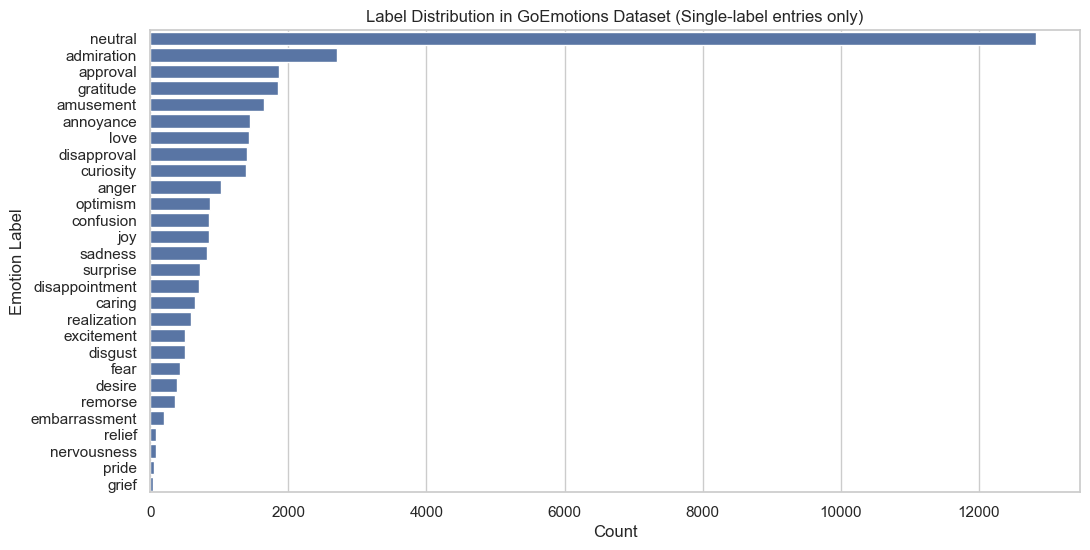

In [3]:
# Explore label distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='label_name', data=df_single, order=df_single['label_name'].value_counts().index)
plt.title("Label Distribution in GoEmotions Dataset (Single-label entries only)")
plt.xlabel("Count")
plt.ylabel("Emotion Label")
plt.show()

In [4]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df_single['text'])
y = df_single['label']

# Train/Test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Vectorization and splitting done.")
print(f"Train set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Vectorization and splitting done.
Train set size: 29046 samples
Test set size: 7262 samples


In [5]:
# Define models with class weighting (for imbalance)
models = {
    'Linear SVM': LinearSVC(class_weight='balanced'),
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced', max_iter=1000),
    'MLP Classifier': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Dictionary to store results
model_results = {}

In [6]:
for name, clf in models.items():
    print(f"Training and evaluating: {name}")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Classification report
    report = classification_report(y_test, y_pred, target_names=label_names, zero_division=0)
    model_results[name] = {
        'model': clf,
        'report': report,
        'predictions': y_pred
    }

    # Print evaluation
    print(f"\n{name} Classification Report:\n")
    print(report)
    print("="*80)

Training and evaluating: Linear SVM

Linear SVM Classification Report:

                precision    recall  f1-score   support

    admiration       0.56      0.56      0.56       542
     amusement       0.69      0.78      0.73       330
         anger       0.35      0.47      0.40       205
     annoyance       0.15      0.08      0.11       290
      approval       0.31      0.21      0.25       375
        caring       0.15      0.30      0.20       130
     confusion       0.17      0.27      0.21       172
     curiosity       0.27      0.13      0.17       278
        desire       0.22      0.53      0.31        78
disappointment       0.10      0.18      0.13       142
   disapproval       0.17      0.15      0.16       280
       disgust       0.24      0.54      0.33       100
 embarrassment       0.05      0.24      0.08        41
    excitement       0.14      0.33      0.20       102
          fear       0.20      0.45      0.28        86
     gratitude       0.91      

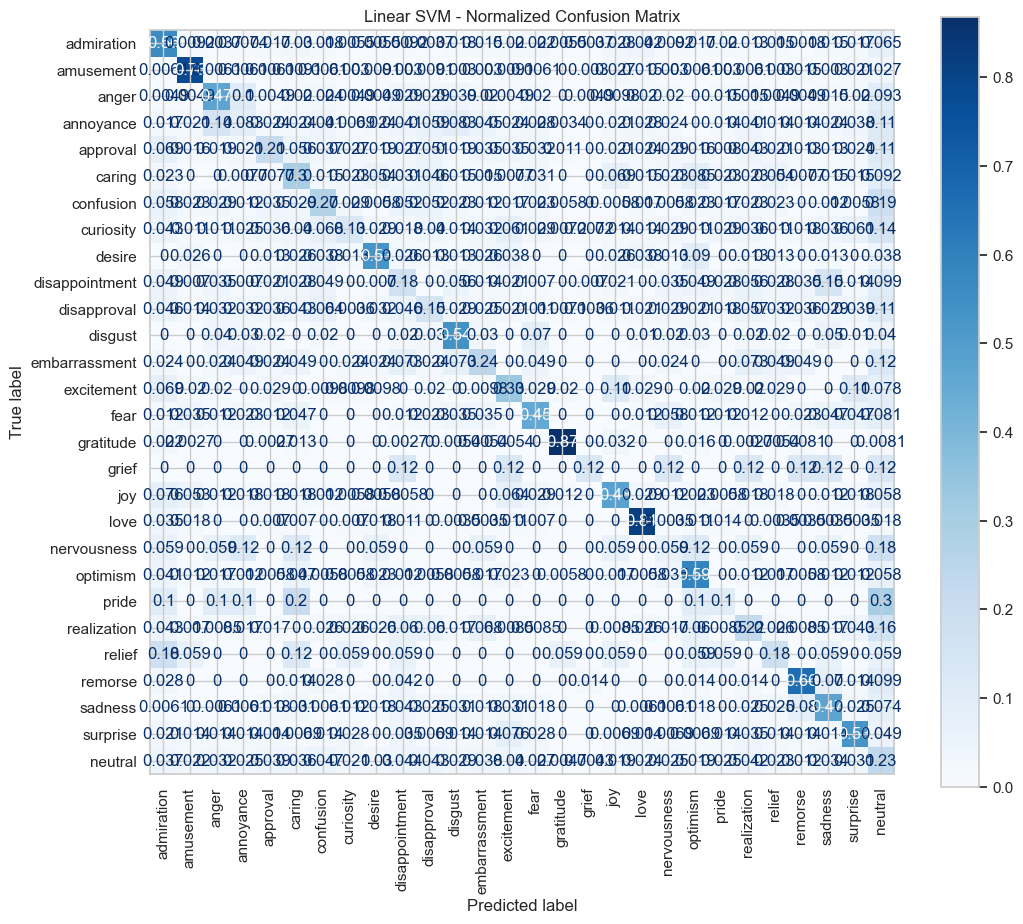

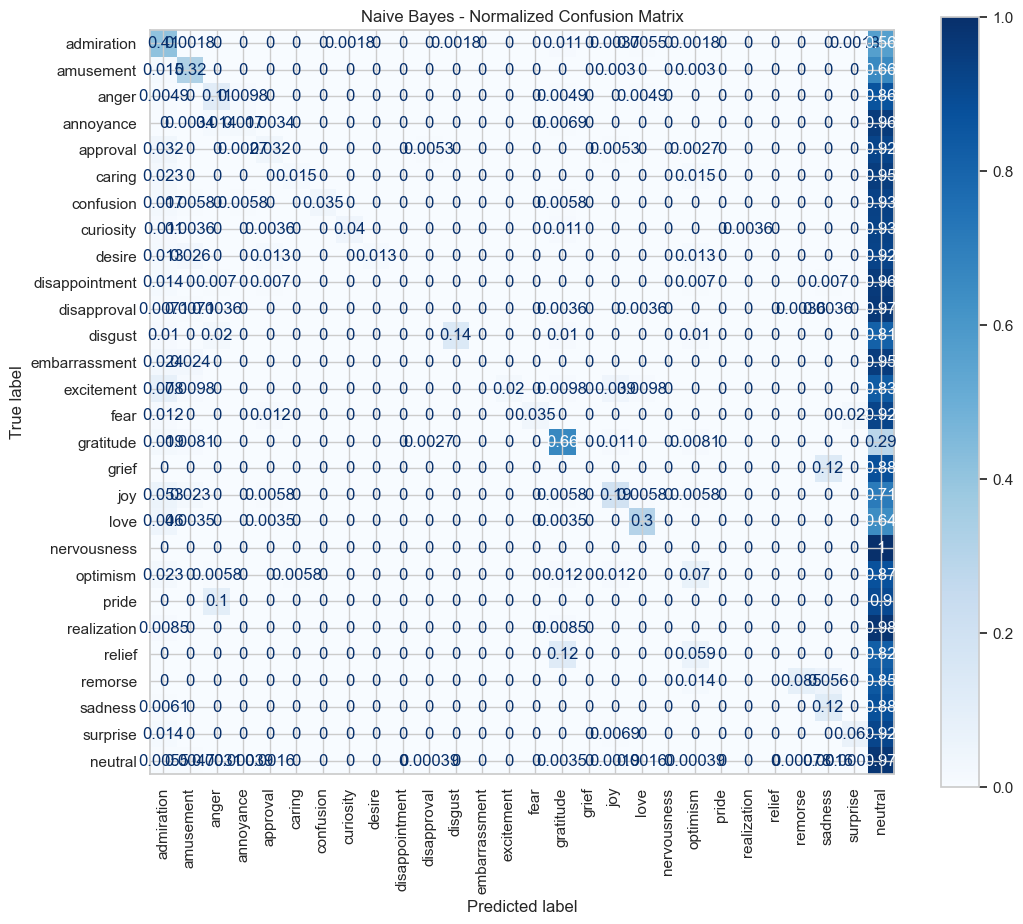

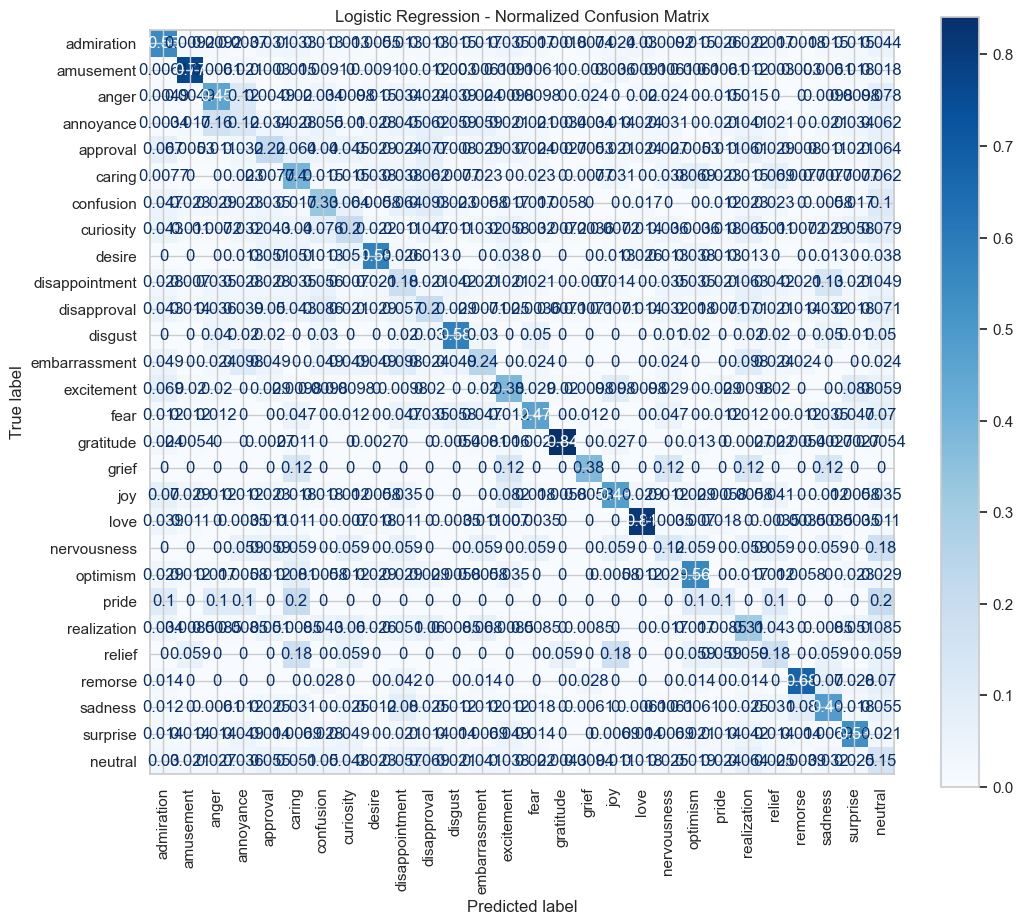

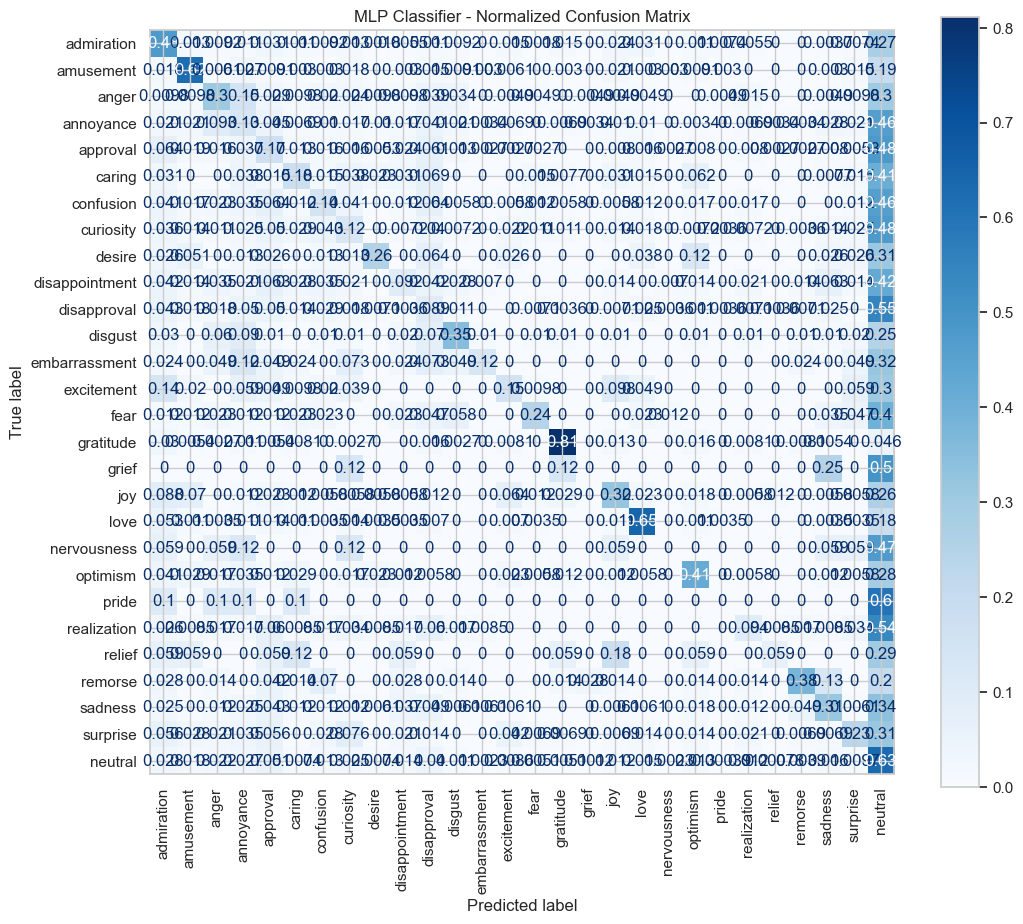

In [10]:
# Visualize confusion matrices for each model 
for name, result in model_results.items():
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, result['predictions'], normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels=label_names)
    disp.plot(cmap='Blues', xticks_rotation='vertical', values_format=None)  # removes text
    plt.title(f"{name} - Normalized Confusion Matrix")
    plt.show()

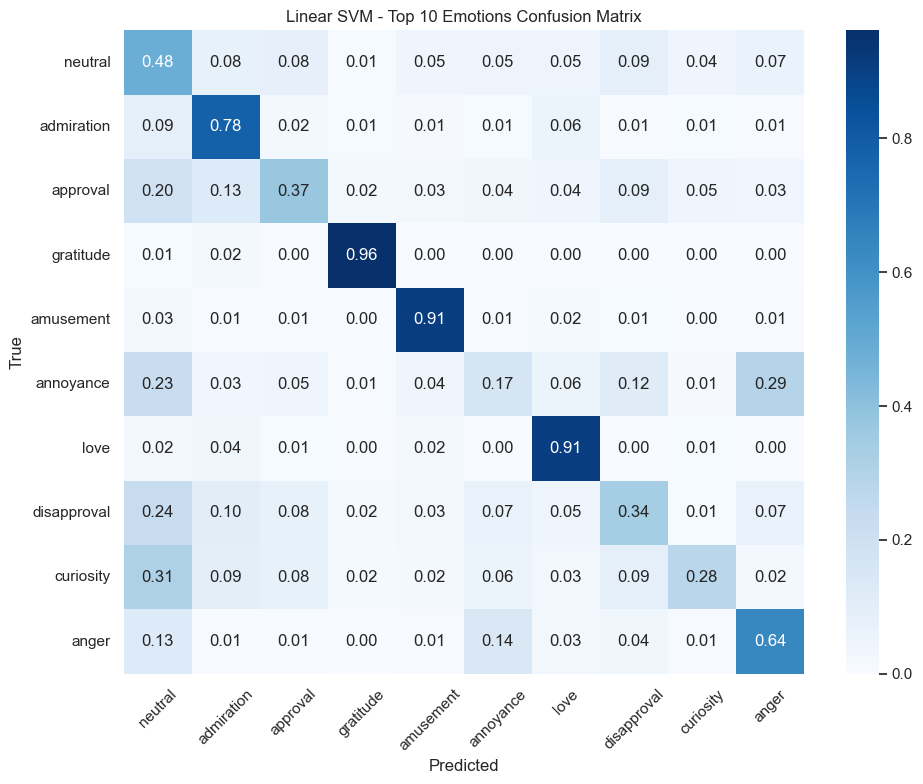

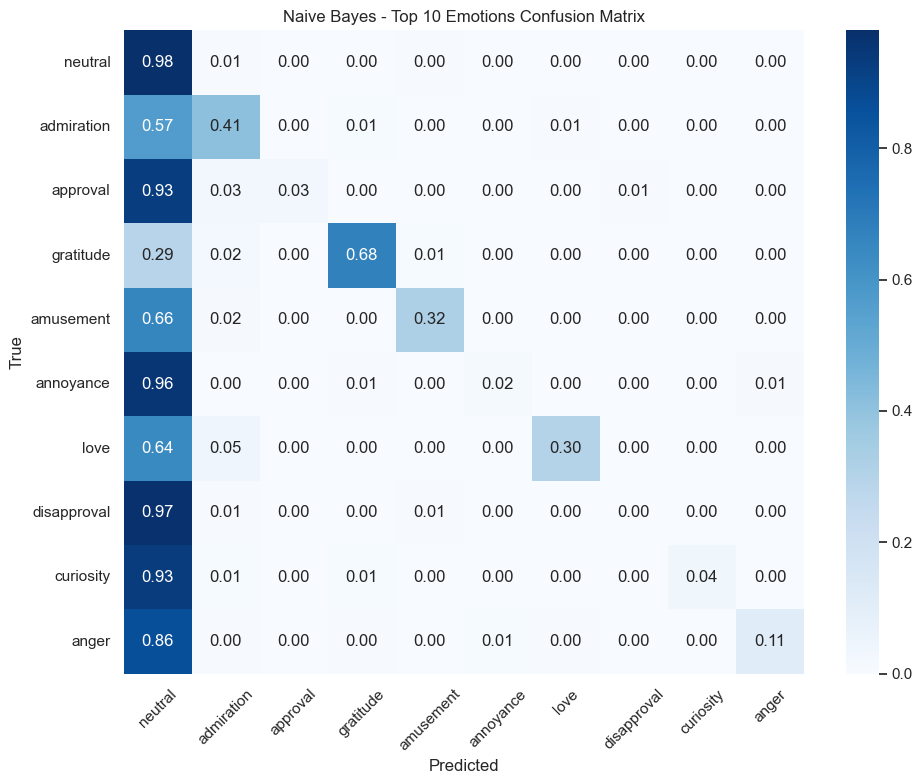

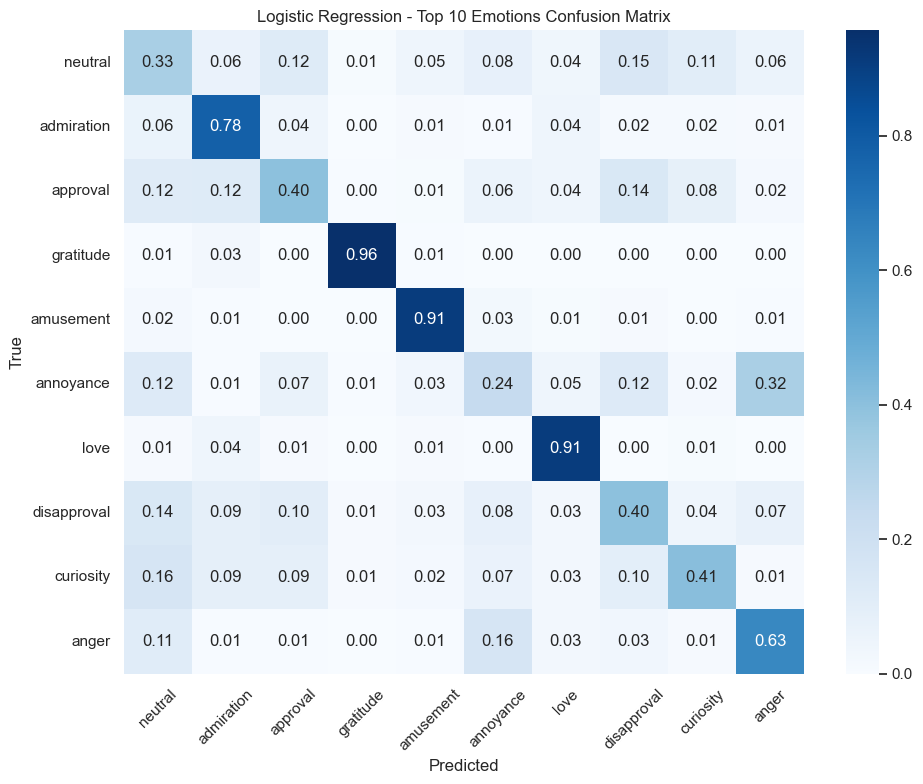

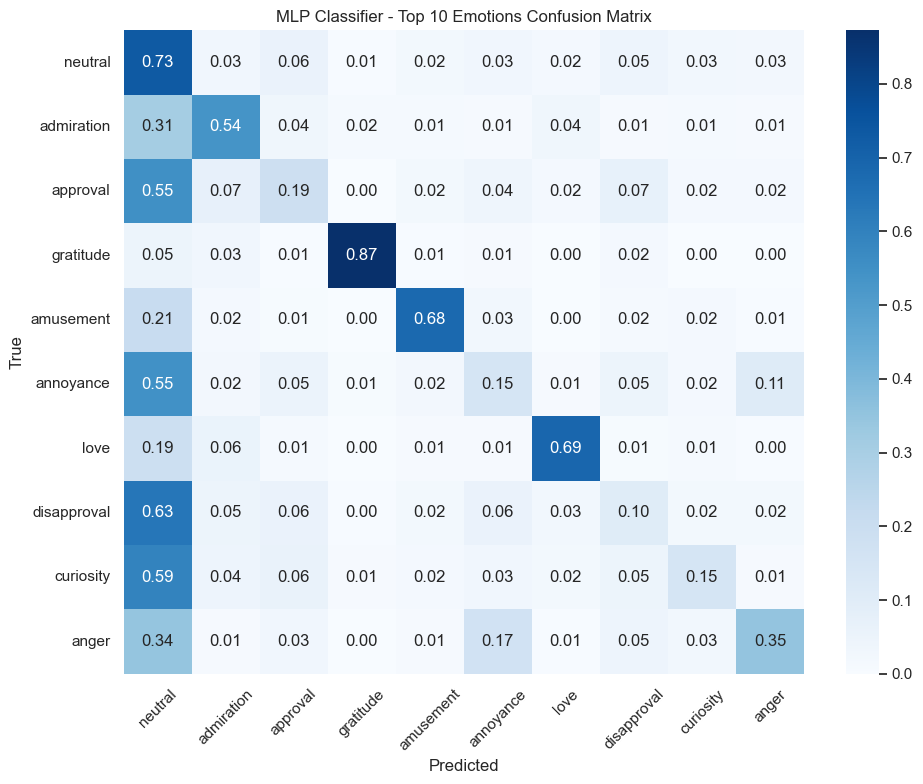

In [15]:
# Visualize only top 10 most frequent labels
# Step 1: Get top 10 most common labels in test set
from collections import Counter

top_10_labels = [label for label, _ in Counter(y_test).most_common(10)]
top_10_names = [label_names[i] for i in top_10_labels]

# Step 2: Confusion matrix filtered to top 10
for name, result in model_results.items():
    y_pred = result['predictions']

    # Filter y_test and y_pred to top 10 only
    mask = [y in top_10_labels for y in y_test]
    y_test_top = [y for i, y in enumerate(y_test) if mask[i]]
    y_pred_top = [y for i, y in enumerate(y_pred) if mask[i]]

    cm_top = confusion_matrix(y_test_top, y_pred_top, labels=top_10_labels, normalize='true')

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_top, xticklabels=top_10_names, yticklabels=top_10_names,
                cmap='Blues', annot=True, fmt=".2f")
    plt.title(f"{name} - Top 10 Emotions Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

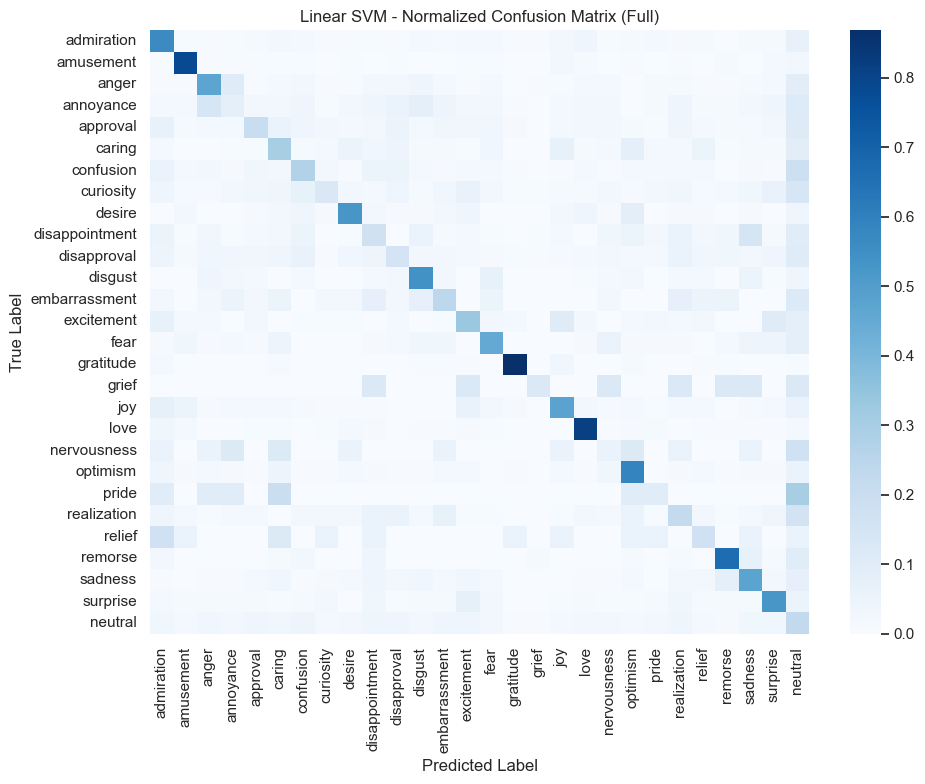

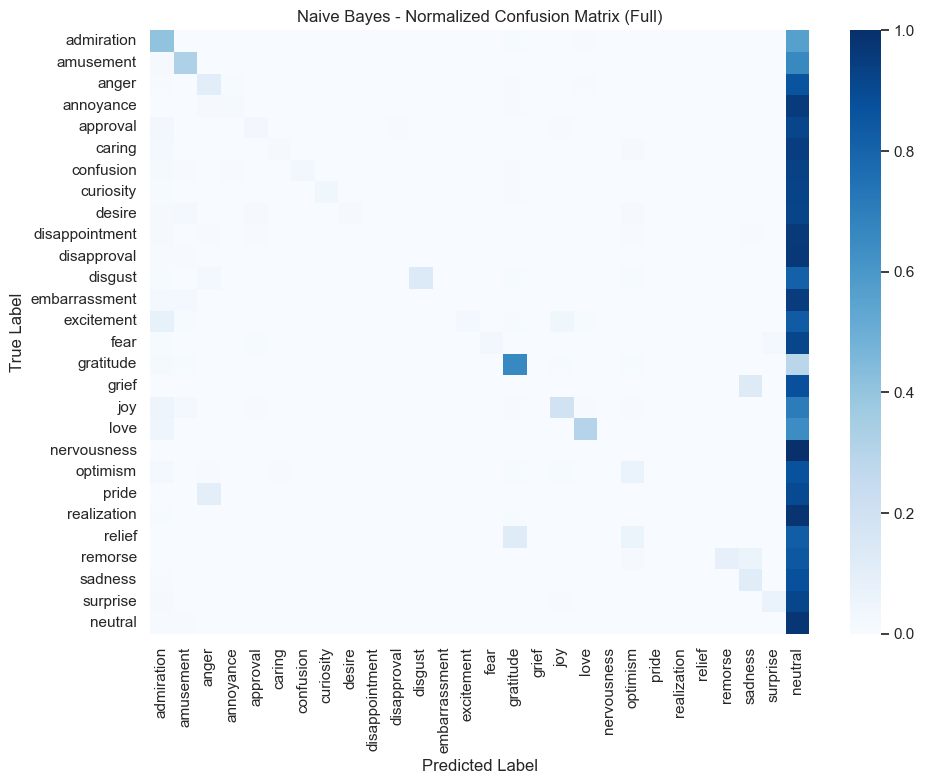

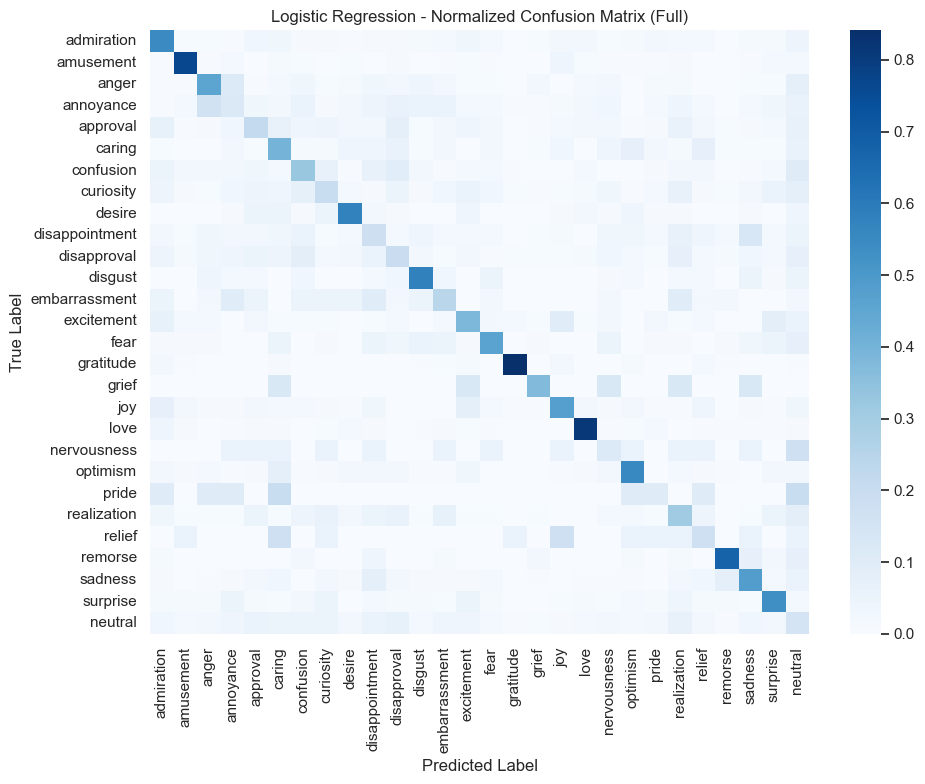

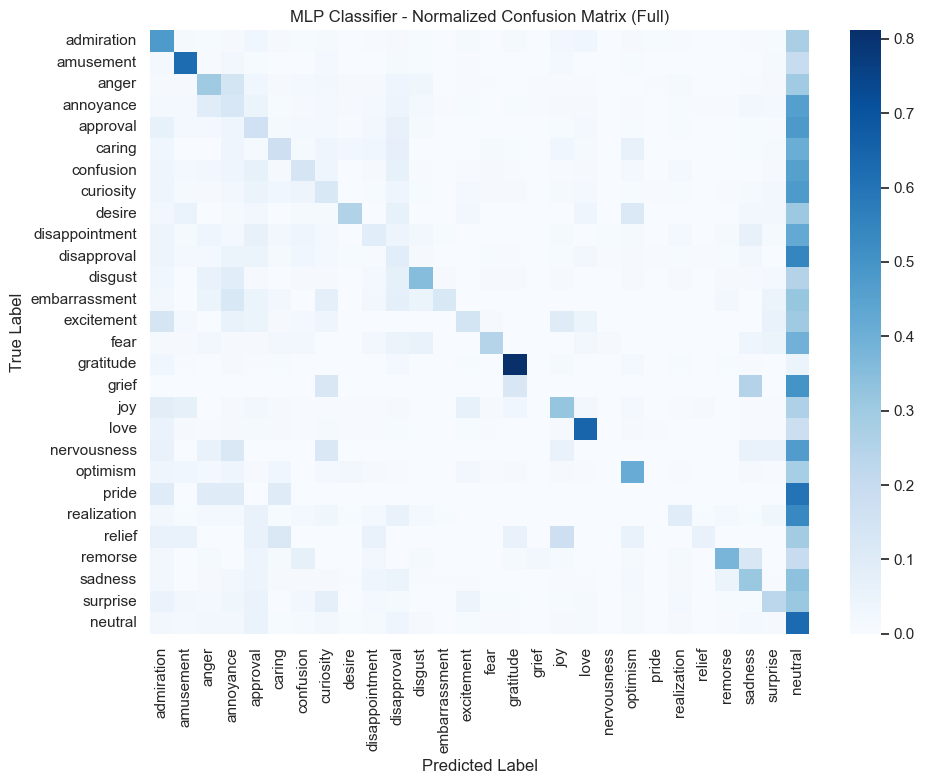

In [14]:
# Visualize using seaborn heatmap instead of visualizing floats (too many == too messy)
for name, result in model_results.items():
    # Normalize confusion matrix
    cm = confusion_matrix(y_test, result['predictions'], normalize='true')

    # Convert to DataFrame for seaborn
    cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)

    # Plot with seaborn
    plt.figure(figsize=(10, 8))  # large enough for all 28 labels
    sns.heatmap(cm_df, cmap='Blues', cbar=True, xticklabels=True, yticklabels=True)

    plt.title(f"{name} - Normalized Confusion Matrix (Full)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


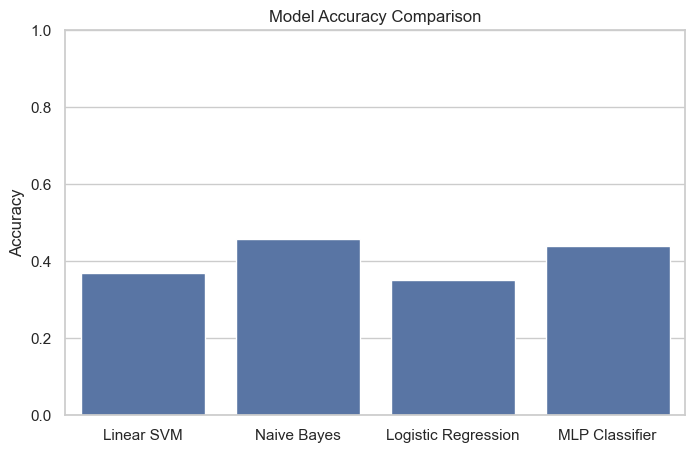

In [8]:
# Compare model accuracies
accuracies = {name: (result['predictions'] == y_test).mean() for name, result in model_results.items()}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.show()
